In [1]:
import pickle, os

home_dir = "../data"

charge_off_classifier_core_pkl = os.path.join(home_dir, "co_clf_core.pkl")

with open(charge_off_classifier_core_pkl,'rb') as f:
    data_df, idx_train, idx_test, idx_validate, clf_core, core_features, analytics = pickle.load(f)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
import operator
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline
from datetime import date,timedelta

import matplotlib.ticker as tkr
from matplotlib import rcParams

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import date,timedelta

In [3]:
# Define train, test, and validate df
train_df    = data_df.loc[idx_train, :]
test_df     = data_df.loc[idx_test, :]
validate_df = data_df.loc[idx_validate, :]

print("Number of loans in Train    set: {}".format(train_df.shape[0]))
print("Number of loans in Test     set: {}".format(test_df.shape[0]))
print("Number of loans in Validate set: {}".format(validate_df.shape[0]))

Number of loans in Train    set: 553049
Number of loans in Test     set: 97597
Number of loans in Validate set: 650647


# Simulation Function

In [4]:
#record the delay according to delay parameter
def loss(row, loss, delay):
    n = int( row["month"] + delay)
    l = row["loss"]
    loss[n] += l
    # add 'return loss' on Mar 28
    return loss

In [5]:
def generate_series(invested_df, loss_delay, diversification_ratio, N = 60):
    # Apply 'payment' function to the input 'invested_df' dataframe.
    df = pd.DataFrame(invested_df.apply(payments, axis=1).to_list(), columns=["int","prn","month", "loss"])
    # Fill N/A with 0.
    int_series = pd.DataFrame(df["int"].to_list()).fillna(value=0).aggregate(sum, axis=0).to_list()
    prn_series = pd.DataFrame(df["prn"].to_list()).fillna(value=0).aggregate(sum, axis=0).to_list()
    
    # For each element, multiply it with a diversification ratio.
    int_series = [i * diversification_ratio for i in int_series]
    prn_series = [i * diversification_ratio for i in prn_series]
    
    # Add 0 to make the length of a specific series as 60.
    int_series += [0]*(N - len(int_series))
    prn_series += [0]*(N - len(prn_series))

    # Define a loss series with the length of 'terms' + 'loss_delay'.
    loss_series = np.zeros(N + loss_delay)
    # 'args' means the other parameters to be passed for the specific function.
    df.apply(loss, axis=1, args=(loss_series, loss_delay))
    
    # For each element, multiply it with a diversification ratio.
    loss_series = [i * diversification_ratio for i in loss_series]
    
    return int_series, prn_series, loss_series

In [6]:
#calculate payments for each loans
def payments(row):
    rate  = float( row['int_rate']/100 )
    rate /= float(12)
    N = int(row['term'])
    if N == 0:
        N = 36
    else:
        N = 60
    
    #load loan parameters
    L = row['funded_amnt']   
    install = row['installment']  
    total_rec_int = row['total_rec_int']
    total_rec_prncp = row['total_rec_prncp']
    recoveries = row['recoveries']
    total_pymnt = row['total_pymnt']
    life_of_loan = int(row['LifeOfLoan'])
    charged_off = (row['LoanStatus'] == 1.0)
    
    int_rec = []
    prn_rec = []
    prn_rem = []
    
    P = L
    tot_int = 0
    tot_prn = 0
    tot_rec = 0
  
    for n in range(N):
      
        # Normal payments
        int_pmnt = P*rate
        prn_pmnt = install - int_pmnt

        # End of interest payments is termination condition
        if not (int_pmnt + tot_int) < total_rec_int:
            #message = "Interest payments terminated"
            int_pmnt = total_rec_int - tot_int
            if (int_pmnt < 0):
             #   print("int neg 1")
                int_rec[-1] += int_pmnt
                break
            prn_pmnt = total_rec_prncp - tot_prn
            tot_int += int_pmnt
            tot_prn += prn_pmnt
            int_rec.append(int_pmnt)
            prn_rec.append(prn_pmnt)
            
            break
 
        # In default, last few payments are considered interest?
        if not (prn_pmnt + tot_prn) < total_rec_prncp:
            prn_pmnt = total_rec_prncp - tot_prn
            int_pmnt = install - prn_pmnt
            
        tot_int += int_pmnt
        tot_prn += prn_pmnt
        
               
        P -= prn_pmnt

        int_rec.append(int_pmnt)
        prn_rec.append(prn_pmnt)
        

    loss = L - tot_prn + recoveries
    
    return int_rec, prn_rec, n, loss

## Dynamic portfolio management function

In [7]:
def check_status(term_ratio,current_df,optimal_threshold):
    #exception catch
    if len(current_df) == 0:
        longer_loan = 0
        risk_loan = 0
        return longer_loan,risk_loan
    
    else:
        #calculate average score
        current_score = current_df['score'].sum()/len(current_df)
        #if current average score is greater than half of our optimal_threshold, we will choose relatively more risky loan next period
        if current_score > 0.5 * optimal_threshold:
            risk_loan = 0
        else:
            risk_loan = 1

        #calculate term structue of current portfolio    
        current_three_year = len(current_df.loc[current_df['term']==0])
        current_five_year = len(current_df) - current_three_year
        if current_five_year ==0:
            ratio = 30
        else:
            ratio = current_three_year / current_five_year
        if ratio > term_ratio:
            longer_loan = 1
        else:
            longer_loan = 0

        return longer_loan,risk_loan

In [20]:
# the new one.
def evaluate_invest(dynamic_management, n,term_ratio,past_investment,sample_df, max_leverage_capital, optimal_threshold, \
                    optimal_diversification_ratio):
    
    OMG = 0
    
    selected_df = sample_df.loc[sample_df.score < optimal_threshold, :]
    selected_df['Simulation_Quarter'] = n
    col = selected_df.columns
    
    
    if len(past_investment) == 0:
        longer_loan = 0
        risk_loan = 0
        current_df = pd.DataFrame(columns=col)
    else:
        current_df = past_investment.loc[(past_investment['Simulation_Quarter']*3 + past_investment['LifeOfLoan']) > n * 3]
        longer_loan,risk_loan = check_status(term_ratio,current_df,optimal_threshold)
    

    # 'max_leverage_capital2' - capital before diversification
    max_leverage_capital2 = max_leverage_capital / optimal_diversification_ratio
    
    invested_df = pd.DataFrame(columns=col)
        
    if dynamic_management:
        for index, row in selected_df.iterrows(): 
            if len(current_df) != 0:
                current_score = current_df['score'].sum()/len(current_df)
            else: 
                current_score = 0.5*optimal_threshold

            if max_leverage_capital2 - row['loan_amnt'] > 0:
                if longer_loan == 1:
                    if (row['term'] != 0):
                        invested_df = invested_df.append(row)
                        max_leverage_capital2 -= row['loan_amnt']
                        current_df = current_df.append(row)
                        longer_loan,risk_loan = check_status(term_ratio,current_df,optimal_threshold)
                else:
                    if (row['term'] != 1):
                        invested_df = invested_df.append(row)
                        max_leverage_capital2 -= row['loan_amnt']
                        current_df = current_df.append(row)
                        longer_loan,risk_loan = check_status(term_ratio,current_df,optimal_threshold)
    else:
        if selected_df['loan_amnt'].sum() * optimal_diversification_ratio > max_leverage_capital:
            invested_df = selected_df.loc[selected_df['loan_amnt'].cumsum() <= max_leverage_capital2, :]
            invested_df['Simulation_Quarter'] = n
            current_df = current_df.append(invested_df)
        else:
            invested_df = selected_df.copy()
            invested_df['Simulation_Quarter'] = n
            current_df = current_df.append(invested_df)
            

    return current_df,invested_df,selected_df


In [9]:
def plot_bank_run(dyn_params, opt_params, equity, income, losses, assets, bankrupt):
    # figure size in inches
    rcParams['figure.figsize'] = 16,9
    rcParams['font.size'] = 16

    plt.tight_layout()


    
    N = len(equity)
    if bankrupt:
        N -= 1
        equity = equity[:N]
        income  = income[:N]
        losses  = losses[:N]
        assets  = assets[:N]

    ax = plt.subplot()
    ax.plot(range(N), equity, 'g', label='Capital', )
    ax.plot(range(N), income,  'c', label='Income')
    ax.plot(range(N), losses,  'r', label='Losses')
#     ax.set_ylim([0,25000000])
    ax.yaxis.set_major_formatter(tkr.StrMethodFormatter('${x:,.0f}'))
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.legend()

    plt.title("Lending Club bank: {0:.0f}Y performance \n Threshold {1:.3f}, leverage {2:2d}:1, diversification_ratio {3:.2f}, Loss delay {4:d}M".format(N/4, opt_params['threshold'], \
            opt_params['leverage_ratio'],opt_params['diversification_ratio'],opt_params['loss_delay']))



    plt.xlabel("Quarters")
    plt.show()

In [10]:
def bank_run(sample_params, opt_params, do_print=False, do_plot=False):
    total_income = []
    total_invested = []
    
    
    #Balance sheet terms
    BS_cash = []
    BS_investment = []
    BS_debt = []
    BS_equity = []
    
    BS_cash_term = 0
    BS_investment_term = 0
    BS_debt_term = 0
    BS_equity_term = 0
    
    # sampled loans
    df_list = sample_params['sample_df_list']
    
    # Initial cash,investment,debt, and equity
    cash = opt_params['starting_capital']
    investment = 0
    debt = 0
    equity = cash + investment - debt
    
    BS_cash_term = cash
    BS_equity_term = cash
    
    

    # BS series to output
    cash_series   = []
    investment_seires = []
    asset_series = []
    debt_series = []
    equity_series =[]
    
    # IS series
    income_series  = []
    losses_series  = []

    # Metrics series
    new_loan_series = []
    
    #Income Statement terms
    IS_interest_receive = []
    IS_interest_pay = []
    IS_loss_recognized = []
    IS_net_income = []
    
    IS_interest_receive_term = 0
    IS_interest_pay_term = 0
    IS_loss_recognized_term = 0
    IS_net_income_term = 0
    
    #output terms
    cash_series   = []
    investment_seires = []
    asset_series = []
    debt_series = []
    equity_series =[]


    payment_series = []
    leverage_series = []
    
    total_selected_amnt = []
    num_of_selected_loans = []
    num_of_default_loans = []
    num_of_36_months = []
    num_of_60_months = []
    
    # Monthly rate on loan
    rate_3M  = (sample_params['inv_cycle'] / 12) * (opt_params['loan_interest_rate']/100 )

    # Set up data structures
    # interest_income, principal_pymt are 180 * 0, loss_recognized is 183 * 0
    interest_income = np.zeros(sample_params['length_of_run']+60)
    principal_pymnt = np.zeros(sample_params['length_of_run']+60)
    loss_recognized = np.zeros(sample_params['length_of_run'] + opt_params['loss_delay'] + 60)

    
    # Initial values for run
    old_loan   = 0
    old_d  = 0
    n = 0
    d = sample_params['inv_cycle']
    bankrupt = False
    term_ratio = opt_params['term_ratio']
    dynamic_management = opt_params['dynamic_management']
    
    past_investment = pd.DataFrame()

    while n < sample_params['length_of_run'] / sample_params['inv_cycle']:
        
        print ("Period ",n)
        
        if do_print:
            print ('initial cash', BS_cash_term)
            print ('initial investment', BS_investment_term)
            print ('initial debt', BS_debt_term)
            print ('initial equity',BS_equity_term) 
            
        new_loan = opt_params['leverage_ratio'] * BS_equity_term
        temp_cash = BS_cash_term
        temp_cash += new_loan
        temp_cash -= old_loan
        max_leverage_capital = max(0, temp_cash)
        
        #print log
        if do_print:
            print ('max_leverage', max_leverage_capital, 'old_loan', old_loan)


        current_df,invested_df, selected_df = evaluate_invest(dynamic_management, n,term_ratio,past_investment, df_list[n], max_leverage_capital,opt_params['threshold'],opt_params['diversification_ratio'])
        
        new_loan = max(invested_df['loan_amnt'].sum()* opt_params['diversification_ratio']-BS_cash_term+old_loan,0)
        leverage = round(new_loan/BS_equity_term,1)
        
        BS_cash_term += new_loan
        BS_debt_term += new_loan

#        Pay back old loan
        BS_cash_term -= old_loan
        BS_debt_term -= old_loan
        
        past_investment = current_df.copy()
        if do_print:          
            print ('borrow amount', new_loan)
            print ('current leverage',leverage) 

        
        
        
        leverage_series.append(leverage)
        
        # Total actually invested
        invested = invested_df['loan_amnt'].sum()*opt_params['diversification_ratio']
        # Update cash balance
        BS_cash_term -= invested
        BS_investment_term += invested
        
        if do_print:
            print ('investment amount', invested)
            print ('after investment cash', BS_cash_term)
            print ('after investment investment', BS_investment_term)
            print ('after investment debt', BS_debt_term)
            print ('after investment equity',BS_equity_term)
        
        #record result_list item
        tot_select_amnt = invested_df['loan_amnt'].sum()
        total_selected_amnt.append(tot_select_amnt)
        num_of_loans = invested_df.shape[0]
        num_of_selected_loans.append(num_of_loans)
        
        df_36m = 0
        df_60m = 0
        df_charged_off = 0
        for t in range(num_of_loans):
            tmp = invested_df.iloc[t,:]
            if tmp.loc['term'] == 0:
                df_36m += 1
            else:
                df_60m += 1
            if tmp.loc['LoanStatus'] == 1:
                df_charged_off += 1
        num_of_default_loans.append(df_charged_off)
        num_of_36_months.append(df_36m)
        num_of_60_months.append(df_60m)
        

        # Calculate outcomes of new investment
        if (len(invested_df) == 0):
            int_series = 0
            prn_series = 0
            lss_series = 0
        else:
            int_series, prn_series, lss_series = generate_series(invested_df, \
                        opt_params['loss_delay'],opt_params['diversification_ratio'])
        temp = []
        temp.append(int_series)
        temp.append(prn_series)
        temp.append(lss_series)
        
        if not (len(invested_df) == 0):
        # Add new outcomes to tails of old outcomes
            interest_income[old_d: len(int_series) + old_d] += int_series
            principal_pymnt[old_d: len(prn_series) + old_d] += prn_series
            loss_recognized[old_d: len(lss_series) + old_d] += lss_series


        # Calculate interest, principal, losses from old_d to d
        int_calc = interest_income[old_d:old_d+d].sum()
        prn_calc = principal_pymnt[old_d:old_d+d].sum()
        loss_calc = loss_recognized[old_d:old_d+d].sum()

        if do_print:
            print ('Int_received',int_calc)
            print ('Principle_received',prn_calc)
            print ('Loss_calc',loss_calc)
        
        
        # Loan interest due
        int_loan = new_loan * (rate_3M)

        if do_print:
            print ('int_loan',int_loan)
            
        # Update cash on hand
        
        if do_print: 
            print ('after_interest_cash',BS_cash_term)
        

        BS_cash_term += int_calc
        BS_equity_term +=int_calc
        
        BS_cash_term += prn_calc
        BS_investment_term -= prn_calc
        
        
        BS_cash_term -= int_loan
        BS_equity_term -= int_loan
        

        BS_investment_term -= loss_calc
        BS_equity_term -= loss_calc
        
        if do_print:
            print ('end cash', BS_cash_term)
            print ('end investment', BS_investment_term)
            print ('end debt', BS_debt_term)
            print ('end equity',BS_equity_term)
        
     
        BS_cash.append(BS_cash_term)
        BS_investment.append(BS_investment_term)
        BS_debt.append(BS_debt_term)
        BS_equity.append(BS_equity_term)

        IS_interest_receive_term = int_calc
        IS_interest_pay_term = int_loan
        IS_loss_recognized_term = loss_calc
        IS_net_income_term = IS_interest_receive_term - IS_interest_pay_term - IS_loss_recognized_term

        IS_interest_receive.append(IS_interest_receive_term)
        IS_interest_pay.append(IS_interest_pay_term)
        IS_loss_recognized.append(IS_loss_recognized_term)
        IS_net_income.append(IS_net_income_term)




        # Record
            # BS series to output
        asset_series.append(BS_cash_term+BS_investment_term)
        equity_series.append(BS_equity_term)
        cash_series.append(BS_cash_term)
        investment_seires.append(BS_investment_term)
        debt_series.append(BS_debt_term)
        
        income_series.append(int_calc - int_loan)
        losses_series.append(loss_calc)
        
        
        new_loan_series.append(new_loan)
        
        payment_series.append(temp)

        # Bankrupt!
        if BS_equity_term < 0:
            bankrupt = True
            print("Bankrupt!")
            break

        # Update
        old_loan  = new_loan
        old_d += d
   
        n+= 1
    
        print (" ")
        
    if do_plot:
        plot_bank_run(sample_params, opt_params, equity_series, income_series, losses_series, asset_series, bankrupt)

    result= []
    BS = []
    IS = []
    Metrics = []
    BS.append(BS_cash)
    BS.append(BS_investment)
    BS.append(BS_debt)
    BS.append(BS_equity)

    IS.append(IS_interest_receive)
    IS.append(IS_interest_pay)
    IS.append(IS_loss_recognized)
    IS.append(IS_net_income)

    Metrics = []
    Metrics.append(new_loan_series)
    Metrics.append(equity_series)
    Metrics.append(income_series)
    Metrics.append(losses_series)
    Metrics.append(asset_series)
    Metrics.append(debt_series)
    Metrics.append(investment_seires)
    Metrics.append(payment_series)
    Metrics.append(interest_income)
    Metrics.append(principal_pymnt)
    Metrics.append(loss_recognized)
    Metrics.append(leverage_series)

    Additional = []
    Additional.append(total_selected_amnt)
    Additional.append(num_of_selected_loans)
    Additional.append(num_of_default_loans)
    Additional.append(num_of_36_months)
    Additional.append(num_of_60_months)


    result.append(BS)
    result.append(IS)
    result.append(Metrics)
    result.append(Additional)

    return bankrupt, result
    

# Simulation


Period  0


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


 
Period  1
 
Period  2


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 
Period  38
 
Period  39
 


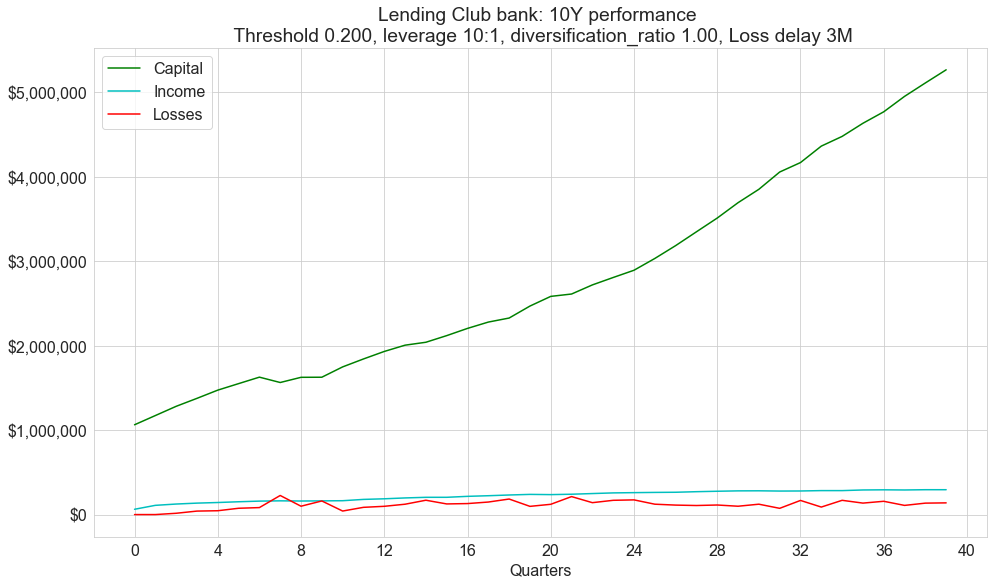

In [12]:
# Generate sample of loans

sample_params = {'inv_cycle':           3,
                 'sample_size':         4000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']

for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

    # Generate sample from validate set
    sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

    # Score sampled data
    sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]
    
    sample_df_list.append(sample_df)
    
    
opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3,
              'threshold':           0.2, 
              'diversification_ratio': 1,
              'term_ratio':     10/1,
              'dynamic_management':  False
             }

Bankrupt, result_list = bank_run(sample_params, opt_params, do_print=False, do_plot=True)


Period  0


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


 
Period  1
 
Period  2
 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 
Period  38
 
Period  39
 


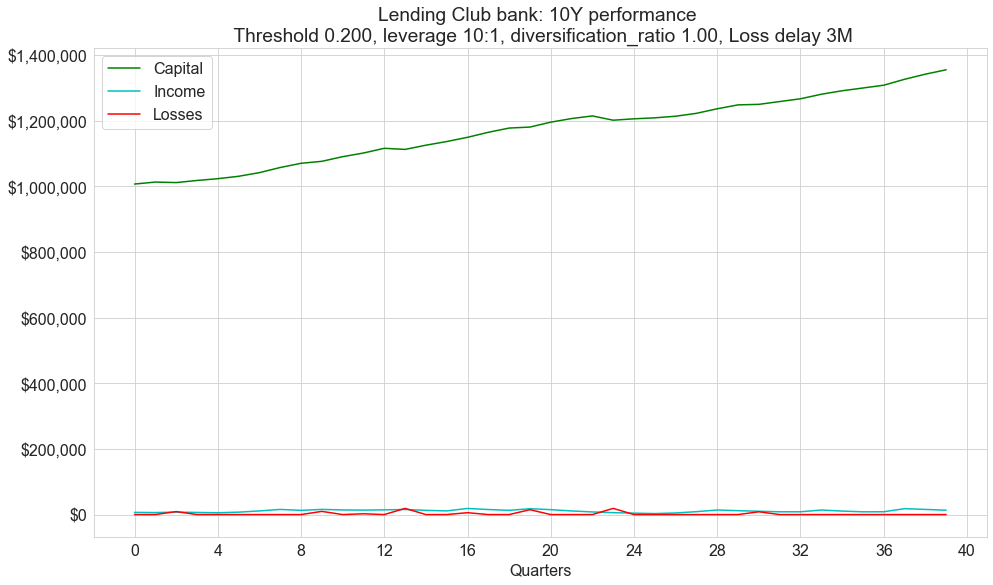

In [11]:
# Generate sample of loans

sample_params = {'inv_cycle':           3,
                 'sample_size':         4000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']

for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

    # Generate sample from validate set
    sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

    # Score sampled data
    sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]
    
    sample_df_list.append(sample_df)
    
    
opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3,
              'threshold':           0.2, 
              'diversification_ratio': 1,
              'term_ratio':     10/1,
              'dynamic_management':  True
             }

Bankrupt, result_list = bank_run(sample_params, opt_params, do_print=False, do_plot=True)


## Test

Period  0
 
Period  1


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 
Period  2
 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 
Period  38
 
Period  39
 


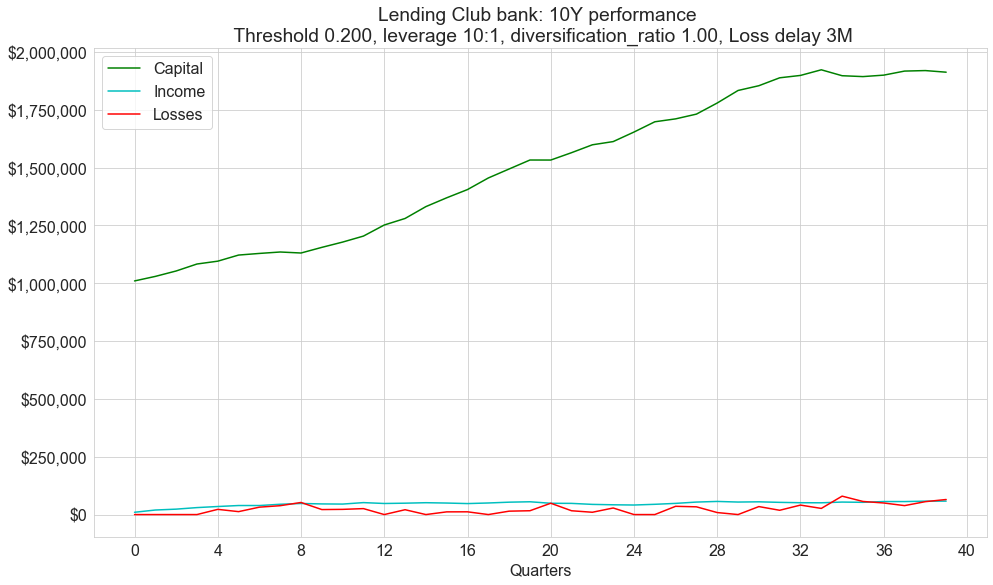

In [112]:
# Generate sample of loans

sample_params = {'inv_cycle':           3,
                 'sample_size':         4000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']

for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

    # Generate sample from validate set
    sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

    # Score sampled data
    sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]
    
    sample_df_list.append(sample_df)
    
    
opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3,
              'threshold':           0.2, 
              'diversification_ratio': 1,
              'term_ratio':     3/1,
              'dynamic_management':  True,
              # 'graph':True
             }

Bankrupt, result_list = bank_run(sample_params, opt_params, do_print=False, do_plot=True)

Period  0


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 
Period  1
 
Period  2
 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 
Period  38
 
Period  39
 


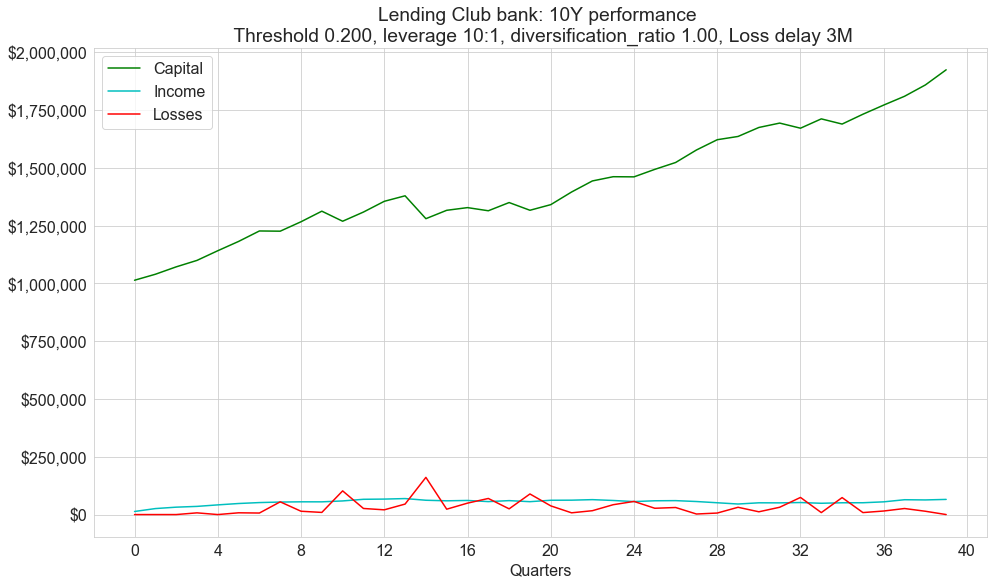

In [51]:
# Generate sample of loans

sample_params = {'inv_cycle':           3,
                 'sample_size':         4000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']

for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

    # Generate sample from validate set
    sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

    # Score sampled data
    sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]
    
    sample_df_list.append(sample_df)
    
    
opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3,
              'threshold':           0.2, 
              'diversification_ratio': 1,
              'term_ratio':     5/1,
              'dynamic_management':  True,
              # 'graph':True
             }

Bankrupt, result_list = bank_run(sample_params, opt_params, do_print=False, do_plot=True)

Period  0


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 
Period  1
 
Period  2
 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 
Period  38
 
Period  39
 


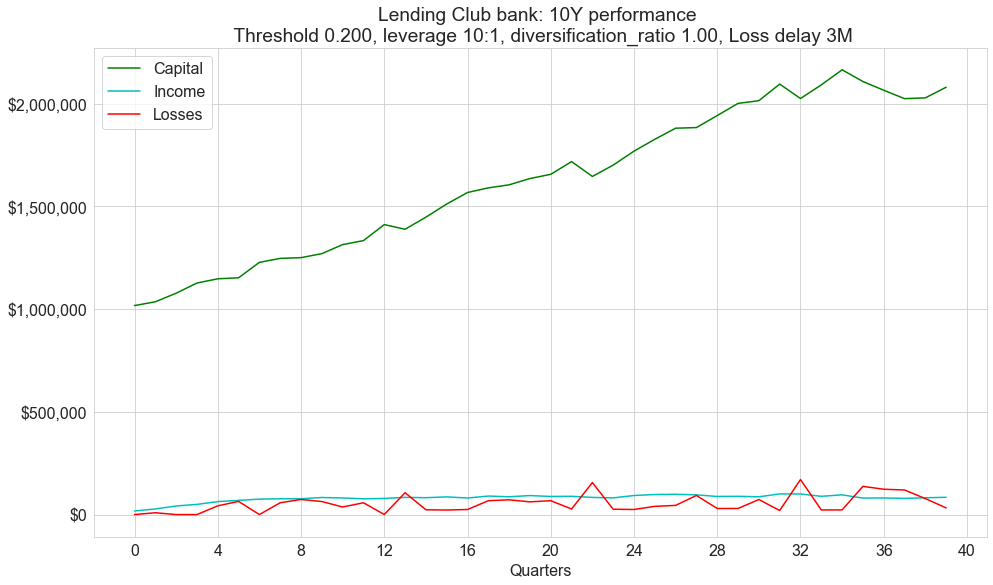

In [52]:
# Generate sample of loans

sample_params = {'inv_cycle':           3,
                 'sample_size':         4000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']

for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

    # Generate sample from validate set
    sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

    # Score sampled data
    sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]
    
    sample_df_list.append(sample_df)
    
    
opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3,
              'threshold':           0.2, 
              'diversification_ratio': 1,
              'term_ratio':     10/1,
              'dynamic_management':  True,
              # 'graph':True
             }

Bankrupt, result_list = bank_run(sample_params, opt_params, do_print=False, do_plot=True)

Period  0


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 
Period  1
 
Period  2
 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 
Period  38
 
Period  39
 


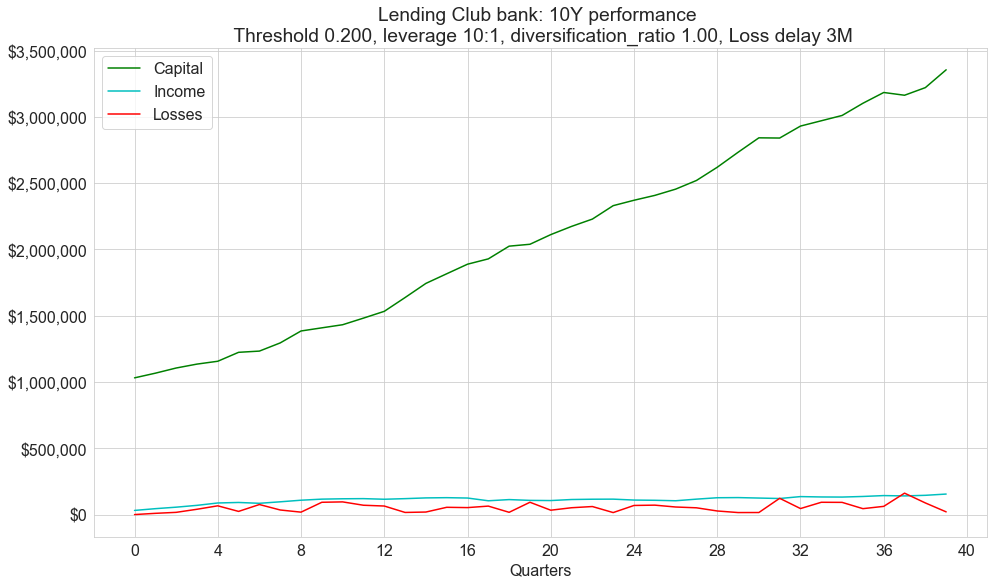

In [53]:
# Generate sample of loans

sample_params = {'inv_cycle':           3,
                 'sample_size':         4000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']

for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

    # Generate sample from validate set
    sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

    # Score sampled data
    sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]
    
    sample_df_list.append(sample_df)
    
    
opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3,
              'threshold':           0.2, 
              'diversification_ratio': 1,
              'term_ratio':     20/1,
              'dynamic_management':  True,
              # 'graph':True
             }

Bankrupt, result_list = bank_run(sample_params, opt_params, do_print=False, do_plot=True)

Period  0


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 
Period  1
 
Period  2
 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 
Period  38
 
Period  39
 


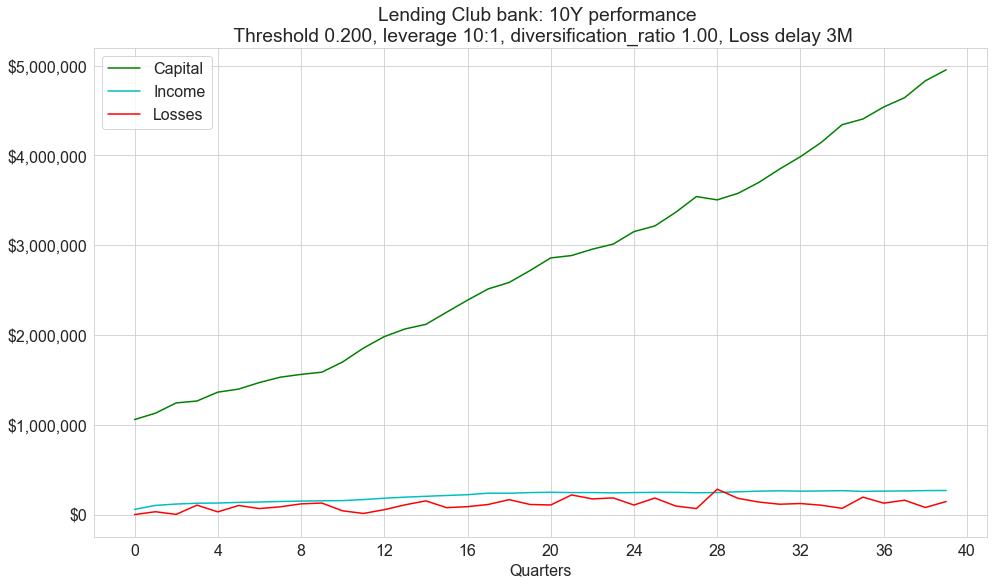

In [54]:
# Generate sample of loans

sample_params = {'inv_cycle':           3,
                 'sample_size':         4000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']

for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

    # Generate sample from validate set
    sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

    # Score sampled data
    sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]
    
    sample_df_list.append(sample_df)
    
    
opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3,
              'threshold':           0.2, 
              'diversification_ratio': 1,
              'term_ratio':     30/1,
              'dynamic_management':  True,
              # 'graph':True
             }

Bankrupt, result_list = bank_run(sample_params, opt_params, do_print=False, do_plot=True)

Period  0


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 
Period  1
 
Period  2
 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 
Period  38
 
Period  39
 


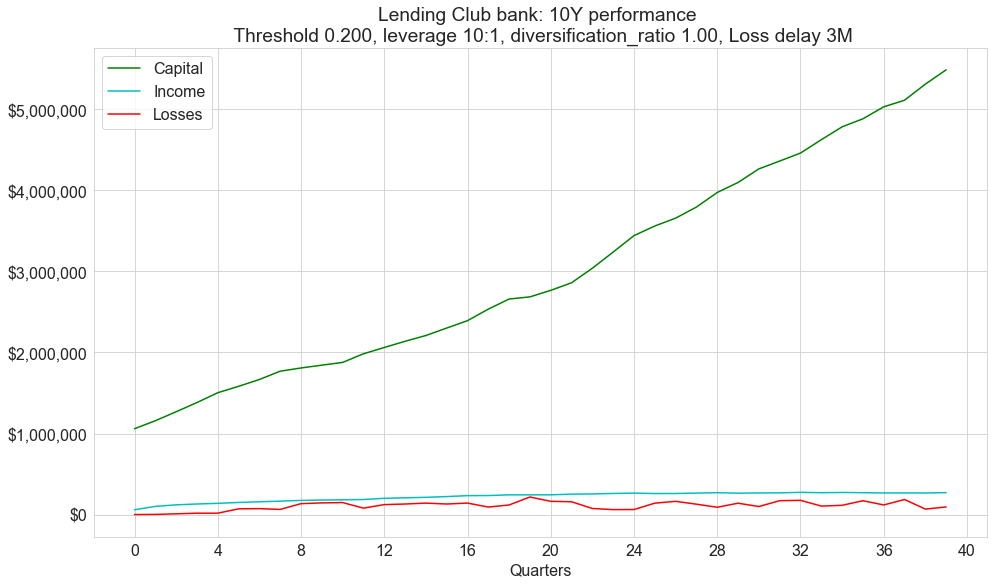

In [55]:
# Generate sample of loans

sample_params = {'inv_cycle':           3,
                 'sample_size':         4000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']

for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

    # Generate sample from validate set
    sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

    # Score sampled data
    sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]
    
    sample_df_list.append(sample_df)
    
    
opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3,
              'threshold':           0.2, 
              'diversification_ratio': 1,
              'term_ratio':     35/1,
              'dynamic_management':  True,
              # 'graph':True
             }

Bankrupt, result_list = bank_run(sample_params, opt_params, do_print=False, do_plot=True)

# term ratio [24 , 32]

In [190]:
graph_capital = []
graph_income = []
graph_loss = []
term_structure = range(24,34,2)
for i in term_structure:
    if i == 0:
        continue
    else:
        print("term_ratio = ", i)
    # Generate sample of loans

    sample_params = {'inv_cycle':           3,
                     'sample_size':         4000,
                     'length_of_run':       120,
                     'sample_df_list':      []
                    }

    sample_df_list = sample_params['sample_df_list']

    for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

        # Generate sample from validate set
        sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

        # Score sampled data
        sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]

        sample_df_list.append(sample_df)


    opt_params = {'loss_delay':          3,
                  'starting_capital':    1e6,
                  'leverage_ratio':      10,
                  'loan_interest_rate':  3,
                  'threshold':           0.2, 
                  'diversification_ratio': 1,
                  'term_ratio':     i/1,
                  'dynamic_management':  True,
                  # 'graph':True
                 }

    Bankrupt, result_list = bank_run(sample_params, opt_params, do_print= False, do_plot= False)
    graph_capital.append(result_list[2][1])
    graph_income.append(result_list[2][2])
    graph_loss.append(result_list[2][3])

term_ratio =  24
Period  0


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 
Period  1
 
Period  2
 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 
Period  38
 
Period  39
 
term_ratio =  26
Period  0
 
Period  1
 
Period  2
 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 

# No dynamic

In [191]:

# Generate sample of loans

sample_params = {'inv_cycle':           3,
                 'sample_size':         4000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']

for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

    # Generate sample from validate set
    sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

    # Score sampled data
    sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]

    sample_df_list.append(sample_df)


opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3,
              'threshold':           0.2, 
              'diversification_ratio': 1,
              'term_ratio':     i/1,
              'dynamic_management':  False,
              # 'graph':True
             }

Bankrupt, result_list = bank_run(sample_params, opt_params, do_print= False, do_plot= False)
graph_capital.append(result_list[2][1])
graph_income.append(result_list[2][2])
graph_loss.append(result_list[2][3])

Period  0
 
Period  1


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 
Period  2


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 
Period  38
 
Period  39
 


# Plot

In [205]:
# set color
term_structure = range(24,34,2)
term_structure = list(term_structure)
last = term_structure[-1] + 1
term_structure.append(last)
color_plot = []
for z in term_structure:
    color_plot.append(plt.cm.Set2(random.choice(range(plt.cm.Set2.N))))

In [206]:
term_structure[-1]

33

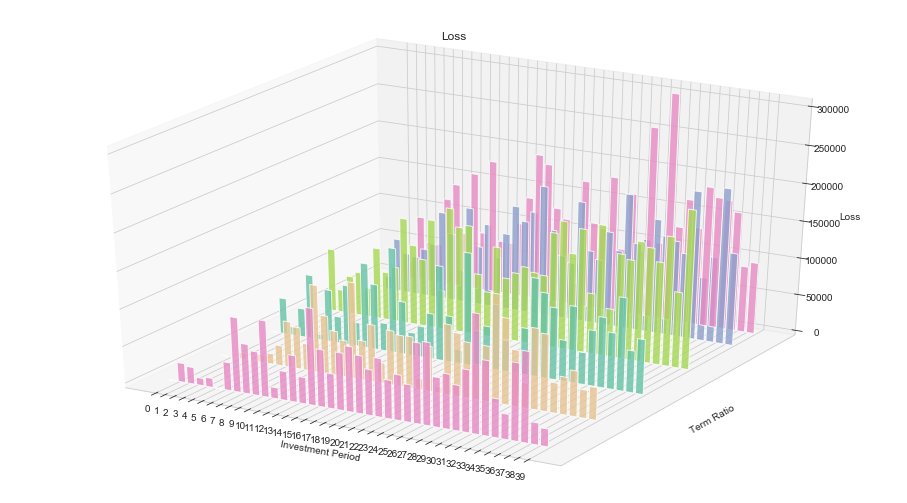

In [207]:
# loss
import random
import matplotlib as mpl
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['font.size'] = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
i = 0
for z in term_structure:
    # print(z)
    xs = range(0,40,1)
    ys = graph_loss[i]
    color = color_plot[i]
    ax.bar(xs, ys, zs=z, zdir='y', color=color, alpha=0.8)
    i+=1
    
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(ys)) 
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(xs))
# ax.zaxis.set_major_locator(mpl.ticker.FixedLocator(term_structure))

ax.set_xlabel('Investment Period')
ax.set_ylabel('Term Ratio')
ax.set_zlabel('Loss')
ax.set_title("Loss")

plt.show()

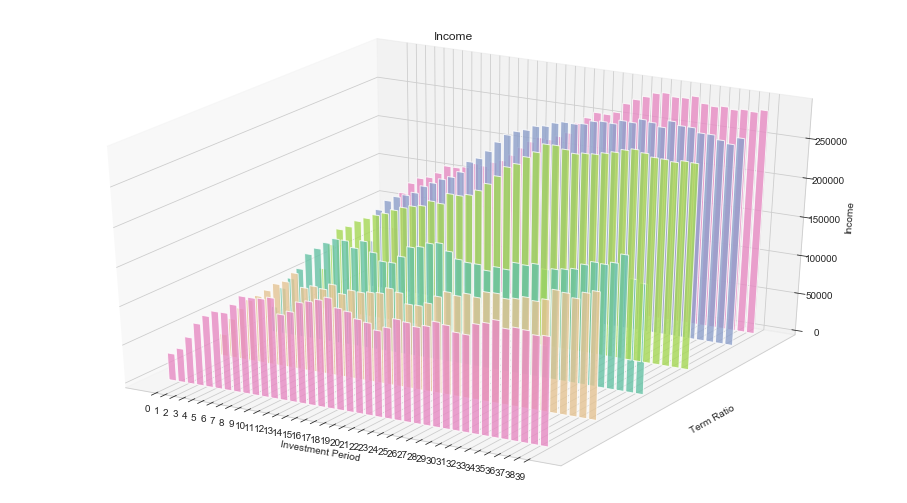

In [208]:
# income
import random
import matplotlib as mpl
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['font.size'] = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
i = 0
for z in term_structure:
    # print(z)
    xs = range(0,40,1)
    ys = graph_income[i]
    color = color_plot[i]
    ax.bar(xs, ys, zs=z, zdir='y', color=color, alpha=0.8)
    i+=1
    
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(ys)) 
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(xs))
# ax.zaxis.set_major_locator(mpl.ticker.FixedLocator(term_structure))

ax.set_xlabel('Investment Period')
ax.set_ylabel('Term Ratio')
ax.set_zlabel('Income')
ax.set_title("Income")

plt.show()

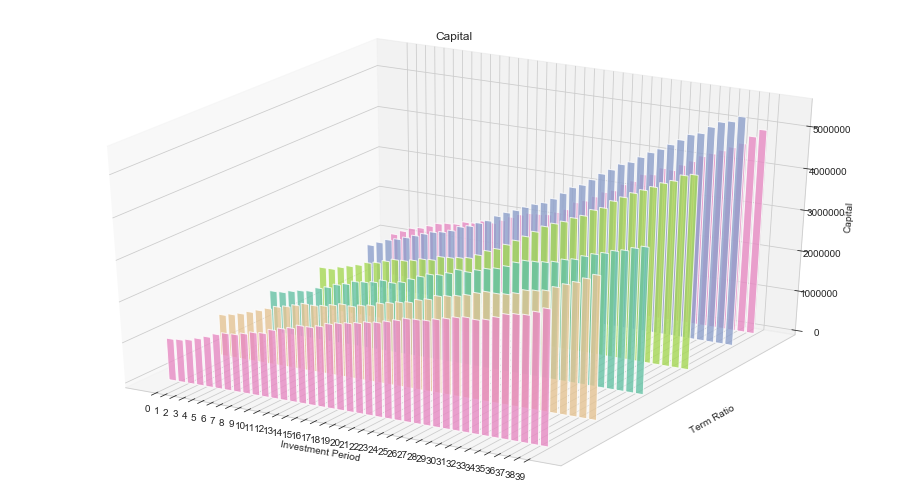

In [209]:
# capital
import random
import matplotlib as mpl
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['font.size'] = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
i = 0
for z in term_structure:
    # print(z)
    xs = range(0,40,1)
    ys = graph_capital[i]
    color = color_plot[i]
    ax.bar(xs, ys, zs=z, zdir='y', color=color, alpha=0.8)
    i+=1
    
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(ys)) 
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(xs))
# ax.zaxis.set_major_locator(mpl.ticker.FixedLocator(term_structure))

ax.set_xlabel('Investment Period')
ax.set_ylabel('Term Ratio')
ax.set_zlabel('Capital')
ax.set_title("Capital")

plt.show()

In [210]:
np.shape(graph_loss)

(6, 40)

In [211]:
term_structure

[24, 26, 28, 30, 32, 33]

# Only Plot 32:1

Period  0


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 
Period  1
 
Period  2
 
Period  3
 
Period  4
 
Period  5
 
Period  6
 
Period  7
 
Period  8
 
Period  9
 
Period  10
 
Period  11
 
Period  12
 
Period  13
 
Period  14
 
Period  15
 
Period  16
 
Period  17
 
Period  18
 
Period  19
 
Period  20
 
Period  21
 
Period  22
 
Period  23
 
Period  24
 
Period  25
 
Period  26
 
Period  27
 
Period  28
 
Period  29
 
Period  30
 
Period  31
 
Period  32
 
Period  33
 
Period  34
 
Period  35
 
Period  36
 
Period  37
 
Period  38
 
Period  39
 


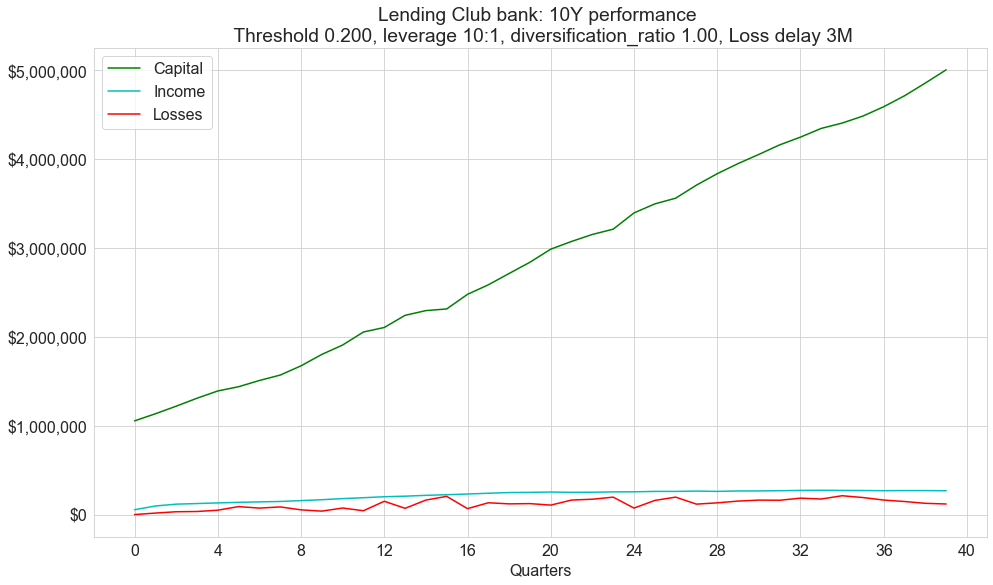

In [11]:
sample_params = {'inv_cycle':           3,
                 'sample_size':         4000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']

for d in range(sample_params['inv_cycle'] ,1 + sample_params['length_of_run'], sample_params['inv_cycle']):

    # Generate sample from validate set
    sample_df = validate_df.sample(sample_params['sample_size'], replace=True)

    # Score sampled data
    sample_df['score'] = clf_core.predict_proba(sample_df[core_features])[:,1]
    
    sample_df_list.append(sample_df)
    
    
opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3,
              'threshold':           0.2, 
              'diversification_ratio': 1,
              'term_ratio':     32/1,
              'dynamic_management':  True,
              # 'graph':True
             }

Bankrupt, result_list = bank_run(sample_params, opt_params, do_print=False, do_plot=True)